# **We briefly implements a Hopfield network as local oprimizer to infer node labels in partially labelled graphs**
* ## The constructor will receive the weight matrix, which in this setting is predefined
* ## The method `run_dynamics` will receive the label vector whose components are in $\{-1, 0, 1\}$ and will run the dynamics only of those labelled by $0$, as seen in the theory session



In [10]:
import numpy as np
# Hopfield network as local optimizer
class HopfieldNetworkLO:
    def __init__(self, weight_matrix):
        """Initialize network with a given weight matrix."""
        self.W = np.array(weight_matrix)  # Convert weight matrix to numpy array
        self.N = self.W.shape[0]  # Number of neurons

    def run_dynamics(self, labels, max_iterations=100):
        """Perform asynchronous updates for neurons labeled as '0'."""
        state = np.array(labels, dtype=float)  # Convert labels to float array
        free_neurons = np.where(state == 0)[0]  # Indices of neurons to update
        fixed_neurons = np.where(state != 0)[0]  # Indices of fixed neurons

        # Compute external influence from fixed neurons
        b = np.dot(self.W[:, fixed_neurons], state[fixed_neurons])  # Activation threshold

        for _ in range(max_iterations):
            updated = False
            for i in free_neurons:
                # Compute total input sum (including fixed neurons' influence)
                activation = np.dot(self.W[i], state) - b[i]
                new_state = 1 if activation > 0 else -1

                if new_state != state[i]:
                    state[i] = new_state
                    updated = True

            if not updated:  # Stop if no changes occur
                break

        return state



# **Testing on a toy example**

In [11]:
# Example: Generate a symmetric random weight matrix
n = 15
W = np.random.randn(n, n)
W = (W + W.T) / 2  # Ensure symmetry
np.fill_diagonal(W, 0)  # No self-connections
#print(W)

def generate_labels(length):
    """Generate a random label array of given length with values in {-1, 0, 1}."""
    return np.random.choice([-1, 0, 1], size=length)
labels = generate_labels(length=n)  # Partial labeling (-1, 1 are fixed; 0 are free to update)

print("Initial state:", labels)
# Initialize and update the network
hopfield_net = HopfieldNetworkLO(W)
inferred_state = hopfield_net.run_dynamics(labels)

print("Final state:", inferred_state)


Initial state: [-1 -1  0  1  1  0  0  1  0  0  0 -1  1  1  1]
Final state: [-1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.]


#  **We are going to implement a convolutional graph neural network using the Keras and TensorFlow libraries**
* # we build a graph neural network for a **node prediction task**

# **DATA**
 * # We use the [Cora](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz) dataset, which consists of academic publications as the **nodes** and the citations between them as the **links**: if publication A cites publication B, then the graph has an edge from A to B. The nodes are classified into one of **seven subjects**, and our model will learn to predict this subject.
* # This data set includes $\color{red}{2708}$ scientific papers  classified in $\color{red}{7}$ classes
* # It has $\color{red}{5429}$ total links.
 * # Each publication in the dataset is described by a **0/1-valued word vector** indicating in a given position the absence/presence of the word associated to that position (a dictionary)
* # The dictionary consists of $\color{red}{1433}$ unique words.

# **Let's start downloading the dataset**
 * # keras ```get_file``` temporary downloads data in the **keras cache** subdir

In [27]:
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)


In [28]:
data_dir = os.path.join(os.path.dirname(zip_file), "cora_extracted/cora")

In [29]:
print(zip_file)
data_dir


/root/.keras/datasets/cora_extracted


'/root/.keras/datasets/cora_extracted/cora'

In [30]:
import os
print(os.listdir("/root/.keras/datasets/cora_extracted"))  # Check extracted folder contents
print(os.listdir("/root/.keras/datasets/cora_extracted/cora"))

['cora']
['cora.cites', 'cora.content', 'README']


# The dataset includes two files

1. # **cora.cites**: Includes the citation records
2. # **cora.content**: Includes the paper content records

# **Let's convert the citation data**
* # Transform **cora.content** into a data frame

In [31]:
import pandas as pd
import numpy as np
citations_data = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)


In [32]:
print("Citations shape:", citations_data.shape)
citations_data.sample(frac=1).head()

Citations shape: (5429, 2)


,target,source
2082,16476,1129621
312,910,436796
2594,28278,1107312
3035,39890,1154229
4542,210309,1111978


# **The data frame has two variables: ```target``` and ```source```**
* # The IDs $\color{red}{are\ not\ sequential}$
* # The count of the total values are 5429

# **Let’s now parse the article contents**
* # convert the **cora.content** into a data frame



In [33]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers_data = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None,
    names=column_names,
)

# Now we display a sample of the papers DataFrame.
* # The DataFrame includes the **paper_id** and the **subject** columns, as well as 1,433 binary column representing whether a word exists in the paper or not.



In [34]:
print("Papers shape:", papers_data.shape)
print(papers_data.head(5).T)

Papers shape: (2708, 1435)
                         0              1                       2  \
paper_id             31336        1061127                 1106406   
term_0                   0              0                       0   
term_1                   0              0                       0   
term_2                   0              0                       0   
term_3                   0              0                       0   
...                    ...            ...                     ...   
term_1429                0              0                       0   
term_1430                0              0                       0   
term_1431                0              0                       0   
term_1432                0              0                       0   
subject    Neural_Networks  Rule_Learning  Reinforcement_Learning   

                                3                      4  
paper_id                    13195                  37879  
term_0                    

# **Let's display the count of the papers in each subject.**

In [35]:
print(papers_data.subject.value_counts())

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


# Let's define an internal integer encode of **between labels/subjects** and of **articles IDs**
* ## We redefine the paper ids from $0$, and accordingly also thw `citation_data`

In [36]:
class_values = sorted(papers_data["subject"].unique())
print(f"class_values:{class_values}")
class_idx = {name: id for id, name in enumerate(class_values)}
num_classes = len(class_idx)
print(f"class_idx:{class_idx},\n num_classes:{num_classes}")
paper_idx = {int(name): idx for idx, name in enumerate(sorted(papers_data["paper_id"].unique()))}
print(f"paper_idx:{paper_idx}")
papers_data["paper_id"] = papers_data["paper_id"].apply(lambda old_id: paper_idx[old_id])
citations_data["source"] = citations_data["source"].apply(lambda old_id: paper_idx[old_id])
citations_data["target"] = citations_data["target"].apply(lambda old_id: paper_idx[old_id])
papers_data["subject"] = papers_data["subject"].apply(lambda value: class_idx[value])
print(citations_data.head())
papers_data.head()

class_values:['Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory']
class_idx:{'Case_Based': 0, 'Genetic_Algorithms': 1, 'Neural_Networks': 2, 'Probabilistic_Methods': 3, 'Reinforcement_Learning': 4, 'Rule_Learning': 5, 'Theory': 6},
 num_classes:7
paper_idx:{35: 0, 40: 1, 114: 2, 117: 3, 128: 4, 130: 5, 164: 6, 288: 7, 424: 8, 434: 9, 463: 10, 504: 11, 506: 12, 887: 13, 906: 14, 910: 15, 936: 16, 940: 17, 941: 18, 943: 19, 1026: 20, 1033: 21, 1034: 22, 1035: 23, 1213: 24, 1237: 25, 1246: 26, 1272: 27, 1365: 28, 1385: 29, 1481: 30, 1688: 31, 1694: 32, 1717: 33, 1786: 34, 1817: 35, 1919: 36, 1949: 37, 1951: 38, 1952: 39, 1953: 40, 1955: 41, 1956: 42, 1959: 43, 1997: 44, 1999: 45, 2354: 46, 2440: 47, 2653: 48, 2654: 49, 2658: 50, 2663: 51, 2665: 52, 2695: 53, 2696: 54, 2698: 55, 2702: 56, 3084: 57, 3085: 58, 3095: 59, 3097: 60, 3101: 61, 3112: 62, 3187: 63, 3191: 64, 3192: 65, 3217: 66, 3218: 67, 3220: 68, 322

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,462,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1911,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
2,2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


# **Implementing the GCN**
 * # this notebook uses a Graph Convolution Network (GCN).
 > * # The core of the GCN neural network model is a “graph convolution” layer.
 > * # This layer is similar to a conventional dense layer, augmented by the graph adjacency matrix to use information about a node’s connections.

* # A basic graph convolution data can consist of the following elements:

 * # **Node features**: Matrix whose row size is the number of nodes, containing the features associated with each node
> * # in our case,  node features are the word-presence binary vectors of each paper/article

 * # **Edges**: This is a sparse matrix of links between the nodes
> * # In our data set, couples $(source,\ target)$ links are the paper citations

 * # **Edge weights**: Optional vector whose size is the number of edges, and whose values represent the weights of  edges.
> * # In our case, there are no weights for the paper citations

In [37]:
import tensorflow as tf
feature_names = set(papers_data.columns) - {"paper_id", "subject"}
num_features = len(feature_names)

list(feature_names)[1:10]

['term_192',
 'term_317',
 'term_1173',
 'term_935',
 'term_634',
 'term_293',
 'term_499',
 'term_1205',
 'term_226']

 * # **Node feaures**

In [38]:
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers_data.sort_values("paper_id")[list(feature_names)].to_numpy(),
    dtype=tf.dtypes.float32
)
print("Nodes shape:", node_features.shape)

Nodes shape: (2708, 1433)


* # **Edges**

In [42]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations_data[["source", "target"]].to_numpy().T
print("Edges shape:", edges.shape)
print("Edges[:5]:", edges[:5])

Edges shape: (2, 5429)
Edges[:5]: [[  21  905  906 ... 2586 1874 2707]
 [   0    0    0 ... 1874 1876 1897]]


 * # **Edge weight**
   *  ## We assume weights are set to $1$, so we need just an array

In [43]:
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])

print("Edges_weights shape:", edge_weights.shape)

Edges_weights shape: (5429,)


# **Randomly splitting in training e test papers**

In [44]:
train_data, test_data = [], []
frac = 0.7
for _, group_data in papers_data.groupby("subject"):
    # Select around 70% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= frac
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1923, 1435)
Test data shape: (785, 1435)


* # Now we can create a graph info tuple that consists of the above-given elements.

In [45]:
graph_info = (node_features, edges, edge_weights)

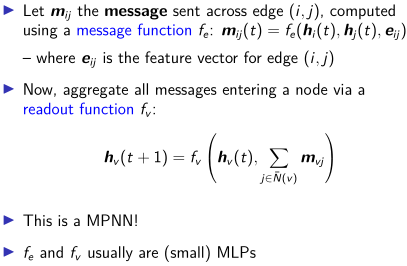

# **Neighborhood Aggregation Strategy and Readout**
 * # GNNs follow an aggregation strategy where we iteratively update the representation of a node by aggregating representations of its neighbors
 * # After $t$  iterations of aggregation, $\color{red}{\text{a node’s representation captures the structural information within its $t$-hop network neighborhood}}$
 * # **We cannot increase too much $t$** because we risk to loose locality

# **STEPS**  
> # **Prepare**: The input node representations are processed (e.g. adding non linearity using a FFNN) to produce a message (function $f_e$). It provides the ${\bf h}_j(t)$. You can simplify the processing by only applying linear transformation to the representations.


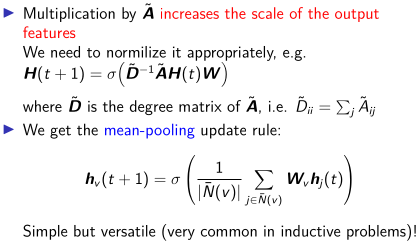

In [46]:
# example of function f_e and f_v
def MLP(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.relu))

    return keras.Sequential(fnn_layers, name=name)

> # **Aggregate**: The messages of the neighbours of each node are aggregated with respect to the ```edge_weights``` using a permutation invariant pooling operation, such as **sum**, **mean**, and **max**, to prepare a single aggregated message for each node. $\color{blue}{\text{Defines the argument of $\sigma$ function}}$.

> * # See, for example, [tf.math.unsorted_segment_sum](https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_sum) APIs used to aggregate neighbour messages

> # **Update**: The ```node_repesentations``` and ```aggregated_messages```, both of shape ```[num_nodes, representation_dim]```, are $\color{blue}{\text{combined and processed to produce the new state}}$ of the node representations (function $f_v$ and $\sigma$)
> * # In this example, the ```node_repesentations``` and ```aggregated_messages``` are added then processed using a FFNN.

In [48]:
# code fo a convolutional layer
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        update_type="MLP",
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.update_type = update_type
        self.normalize = normalize

        self.prepare_fun = MLP(hidden_units, dropout_rate)

        if update_type == "MLP":
          self.update_fun = MLP(hidden_units, dropout_rate)
        # else .....

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.prepare_fun(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges], indices of the neighbours.
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].

        h = node_repesentations + aggregated_messages


        # Apply the processing function (f_v).
        node_embeddings = self.update_fun(h)

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        # Gather slices from node_repesentations according to neighbour_indices
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

# **Implement a graph neural network node classifier**
* # **STEPS**
> 1. # Apply preprocessing using FFNN to the node features to generate initial node representations.
> 2.# Apply one or more graph convolutional layer to the node representation to produce node embeddings
> 3.# Apply post-processing using FFNN to the node embeddings to generate the final node embeddings
> 4. # Feed the node embeddings in a ```Softmax``` layer to predict the node class (classification block in general)

* # $\color{blue}{\text{Each graph convolutional layer added captures information from a further level of neighbours}}$
> * # **However, adding many graph convolutional layer can cause *oversmoothing*, where the model produces similar embeddings for all the nodes**

* # $\color{blue}{\text{Note that the 'graph_info' is passed to the constructor of the Keras model, and used as a property}}$ of the Keras model object, rather than input data for training or prediction
> * # The model will accept a batch of **node indices**, which are used to lookup the **node features** and **neighbours** from the ```graph_info```

In [49]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info, # triple:nodes, edges, weights structures
        num_classes,
        hidden_units,# to be used in function MLP
        aggregation_type="mean",
        update_type="MLP",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features,
        #    edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1. tf.math.reduce_sum()
        #    computes the sum of elements across dimensions of a tensor.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = MLP(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            update_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            update_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = MLP(hidden_units, dropout_rate, name="postprocess")
        # Create a compute output layer.
        self.compute_out = layers.Dense(units=num_classes,
                                        activation="softmax",
                                        name="out")

    def call(self, input_node_indices):
        # input_node_indices represent our ```batch```
        # Preprocess the node_features to produce node representations.
        #  that is, nodes features are pre-embedded before graph convolution
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
          # Skip connection.
          #x = x1 + x
        # no skip connection
        x=x1
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
           # Skip connection.
           #x = x2 + x
        # no skip connection
        x = x2
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        out = self.compute_out(node_embeddings)
        return out

# **Let's test instantiating and calling the GNN model**
> * # Notice that if you provide N node indices, the output will be a tensor of shape $\color{red}{[N,\ num\_classes]}$, regardless of the size of the graph.

In [103]:
# dimension of last hidden layer will be the node-embedding dimension
hidden_units = [64, 32]
dropout_rate = 0.2

# graph_info = (node_features, edges, edge_weights)
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)
# Convert list of indices to a Tensor
node_indices = tf.convert_to_tensor([1, 10, 100], dtype=tf.int32)

# invoking a prediction for nodes of indices 1, 10, 100
print("GNN output without training:", gnn_model(node_indices))

history=gnn_model.summary()

GNN output without training: tf.Tensor(
[[0.12751094 0.13609652 0.15595782 0.1470736  0.14708474 0.1415104
  0.14476602]
 [0.1329194  0.14586227 0.15989664 0.14682351 0.13789184 0.14094526
  0.13566114]
 [0.13198219 0.13780454 0.15433708 0.14202428 0.14687172 0.1382606
  0.1487196 ]], shape=(3, 7), dtype=float32)


Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ (2708, 32)             │        99,844 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv1 (GraphConvLayer)    │ ?                      │         9,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv2 (GraphConvLayer)    │ ?                      │         9,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ (2708, 32)             │         4,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (3, 7)                 │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,955 (480.29 KB)

 Trainable params: 119,001 (464.85 KB)

 Non-trainable params: 3,954 (15.45 KB)

# **Creating training and test set**


In [104]:
# Create train and test features as a numpy array.
x_train = train_data[list(feature_names)].to_numpy()
x_train = train_data.paper_id.to_numpy()
x_test = test_data[list(feature_names)].to_numpy()
x_test = test_data.paper_id.to_numpy()

# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]
print(f"y_train.shape:{y_train.shape}")
print(f"x_train.shape:{x_train.shape}")

y_train.shape:(1923,)
x_train.shape:(1923,)


# **Train the GNN model**
 * # Note that we use the standard supervised cross-entropy loss to train the model.
 * # However, we can add another self-supervised loss term for the generated node embeddings
> * # e.g. that makes sure that **neighbouring nodes in graph have similar representations**, while **faraway nodes have dissimilar representations**

In [105]:
learning_rate = 0.001

gnn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
)
# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", mode= 'max', patience=10, restore_best_weights=True
)

In [106]:
#x_train = train_data[list(feature_names)].to_numpy()
#x_train = train_data.paper_id.to_numpy()
#x_test = test_data[list(feature_names)].to_numpy()
#x_test = test_data.paper_id.to_numpy()
num_epochs = 200
batch_size = 128
# Fit the model.
history = gnn_model.fit(
    x=x_train,
    y=y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stopping],
)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 509ms/step - accuracy: 0.2821 - loss: 1.8994 - val_accuracy: 0.3472 - val_loss: 1.8057
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.3081 - loss: 1.8100 - val_accuracy: 0.3472 - val_loss: 1.6977
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3072 - loss: 1.6601 - val_accuracy: 0.4352 - val_loss: 1.5267
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4869 - loss: 1.4315 - val_accuracy: 0.5181 - val_loss: 1.4174
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5351 - loss: 1.2339 - val_accuracy: 0.5492 - val_loss: 1.3271
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7295 - loss: 0.9934 - val_accuracy: 0.5648 - val_loss: 1.2583
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7614 - loss: 0.8034 - val_accuracy: 0.5907 - val_loss: 1.1856
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8265 - loss: 0.5989 - val_accuracy:

In [107]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    ax2.plot(history.history["val_accuracy"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

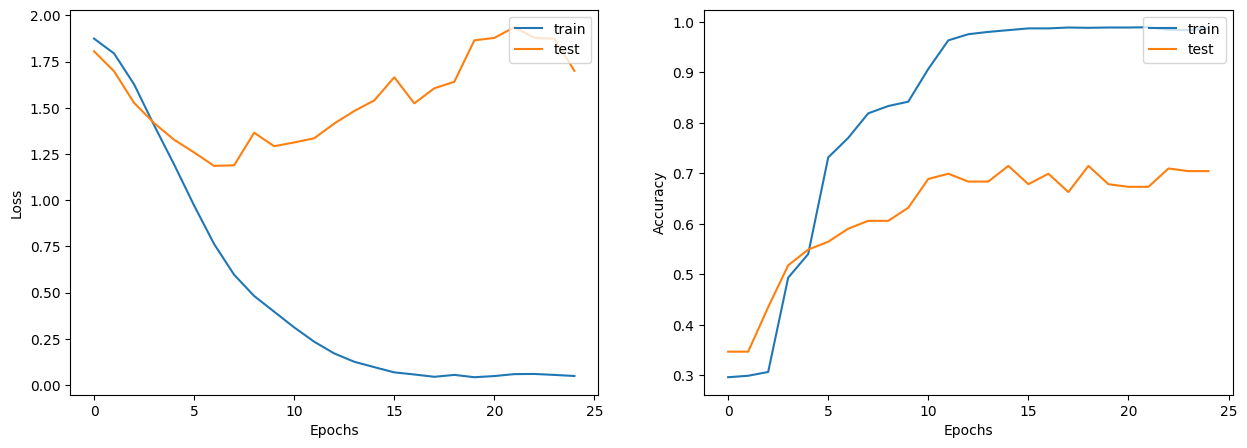

In [108]:
display_learning_curves(history)


# Now we evaluate the GNN model on the test data split

In [109]:
print(x_test[1:10])
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

[2572 1238 1180  528 1620  762 1316 2407 1590]
Test accuracy: 64.2%


In [110]:
print(gnn_model.predict(tf.convert_to_tensor([1, 10], dtype=tf.int32)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
[[1.4675012e-03 9.9377102e-01 3.1053759e-03 3.7081634e-05 5.8551348e-05
  6.2975560e-05 1.4975843e-03]
 [9.5465922e-01 1.9448923e-02 3.6418578e-03 7.4269562e-03 2.9543642e-04
  7.2861402e-03 7.2414903e-03]]


# **Create a baseline model and assess its performance**

* # In this model the inputs are not indices, but feature vectors

In [136]:
hidden_units = [64, 32]
dropout_rate = 0.2
nblocks = 5
print(num_features)
def create_baseline_model(hidden_units, input_size, num_classes, blocks=4,
                          dropout_rate=0.2):
    inputs = layers.Input(shape=(input_size,), name="input_features")
    x = MLP(hidden_units, dropout_rate, name=f"MLP_block1")(inputs)
    for block_idx in range(blocks):
        # Create an FFN block.
        x1 = MLP(hidden_units, dropout_rate, name=f"MLP{block_idx + 2}")(x)

          # Add skip connection.
          #x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
        # no skip connection
        x = x1
    # Compute outpput.
    out = layers.Dense(num_classes, activation="softmax")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=out, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_features, num_classes,
                                       nblocks, dropout_rate)
baseline_model.summary()

1433


Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_features (InputLayer)     │ (None, 1433)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MLP_block1 (Sequential)         │ (None, 32)             │        99,844 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MLP2 (Sequential)               │ (None, 32)             │         4,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MLP3 (Sequential)               │ (None, 32)             │         4,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MLP4 (Sequential)               │ (None, 32)             │         4,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MLP5 (Sequential)               │ (None, 32)             │         4,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MLP6 (Sequential)               │ (None, 32)             │         4,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,955 (480.29 KB)

 Trainable params: 119,001 (464.85 KB)

 Non-trainable params: 3,954 (15.45 KB)

# The GCN model had $122955$ parameters
* # Baseline model has $122,955$ parameters, almost the same

# **Let's train it on the same training data**

In [137]:

learning_rate = 0.0005

baseline_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
)
# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", mode= 'max', patience=10, restore_best_weights=True
)

In [138]:
x_train = train_data[list(feature_names)].to_numpy()
x_test = test_data[list(feature_names)].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]
print("Train data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

num_epochs = 200
batch_size = 128
# Fit the model.
history_ = baseline_model.fit(
    x=x_train,
    y=y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stopping],
)

Train data shape: (1923, 1433)
Test data shape: (785, 1433)
Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 712ms/step - accuracy: 0.1241 - loss: 2.4202 - val_accuracy: 0.1606 - val_loss: 1.9401
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1316 - loss: 2.3331 - val_accuracy: 0.3472 - val_loss: 1.9267
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1439 - loss: 2.1792 - val_accuracy: 0.3472 - val_loss: 1.9123
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1694 - loss: 2.1432 - val_accuracy: 0.3472 - val_loss: 1.8909
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1855 - loss: 2.0840 - val_accuracy: 0.3472 - val_loss: 1.8692
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1972 - loss: 2.0281 - val_accuracy: 0.3472 - val_loss: 1.8497
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2128 - loss: 1.9893 - val_accuracy: 0.3472 - val_loss: 1.8324
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [139]:
print(x_test[0:2, :])
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Test accuracy: 29.55%


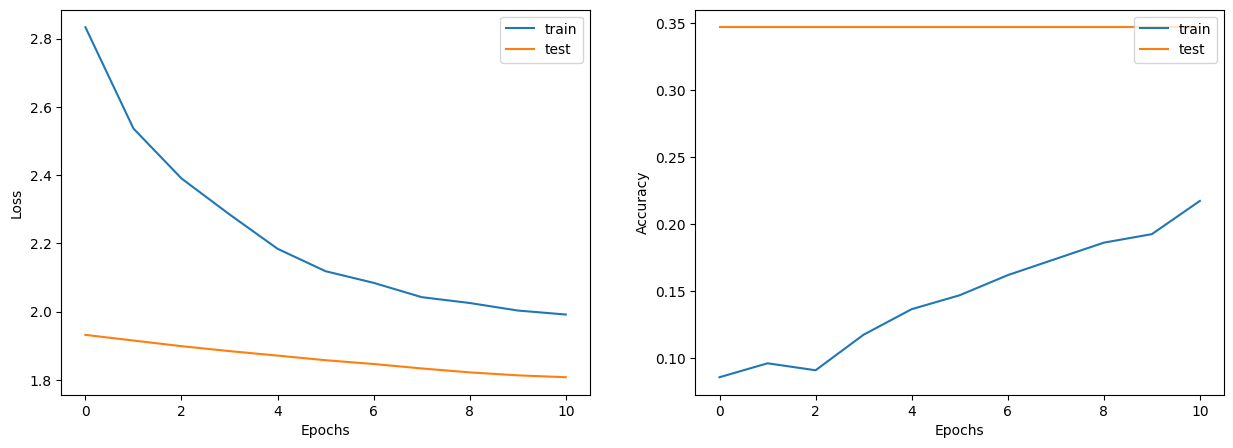

In [135]:
display_learning_curves(history_)


# **Exercise**
# Considering the classes ```GNNNodeClassifier``` and ```GraphConvLayer```, try to verify (one at time, not all together):
* # 1. How much the **complexity of model ```MLP```** impact on the performance. In particular, test (individually):  
> * # The impact of the hidden activation function of ```MLP``` (instead of ReLU)
> * # The impact of the number of hidden units (start by reducing them, to check potential oversizing)
> * # The impact of the number of hidden layers (like above)
* # 2. If **preparing messages** helps (e.g. using identity as ```prepare``` in class ```GraphConvLayer```)
* # 3. Different **aggreagation function** other than mean (*max* and *sum*)
* # 4. Using different functions for the **```prepare``` and ```update``` functions** in class ``GraphConvLayer```
* # 5. The impact of the **node embedding size** (in our experiment was set to $32$, second hidden dimension of the ```MLP``` used as update function)
* # 6. Which is the impact on the test accuracy when the **number of convolutional layers** varies
* # 7. Preprocessing and Postprocessing helps?

# Try to deduce some conclusions as well.